<a href="https://colab.research.google.com/github/123shwetarohokale/563-ShwetaR/blob/main/MDProject2_Shweta_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

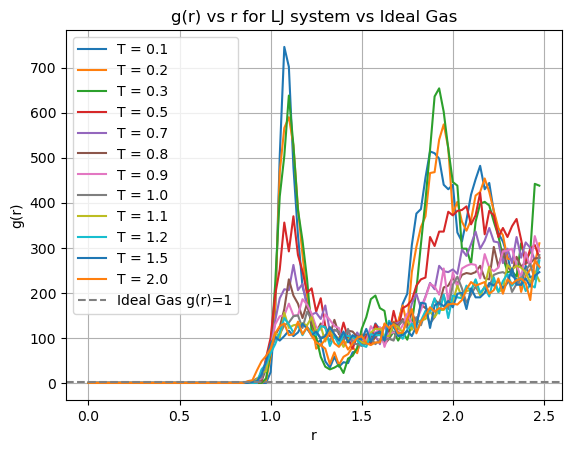

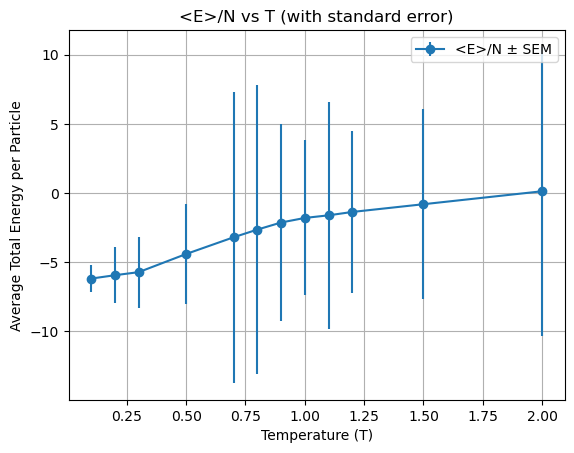

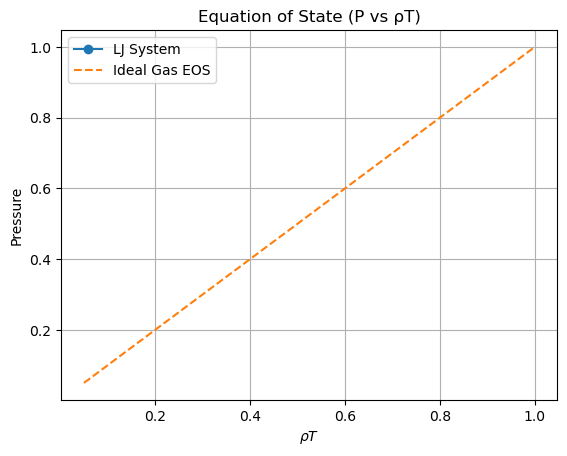

Equilibrated after 10,000 steps.
Sampled 20 independent configurations (500 steps apart).
Standard error (SEM) at selected points:
  T = 0.10 → <E>/N = -6.1867 ± 0.9677
  T = 0.20 → <E>/N = -5.9439 ± 2.0400
  T = 0.30 → <E>/N = -5.7227 ± 2.5732
  T = 0.50 → <E>/N = -4.4107 ± 3.6181
  T = 0.70 → <E>/N = -3.2016 ± 10.5287
  T = 0.80 → <E>/N = -2.6459 ± 10.4537
  T = 0.90 → <E>/N = -2.1346 ± 7.0872
  T = 1.00 → <E>/N = -1.8034 ± 5.6013
  T = 1.10 → <E>/N = -1.6150 ± 8.2091
  T = 1.20 → <E>/N = -1.3710 ± 5.8391
  T = 1.50 → <E>/N = -0.8116 ± 6.8832
  T = 2.00 → <E>/N = 0.1250 ± 10.4347


In [ ]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt

# Initialize device and simulation
device = hoomd.device.CPU()
sim = hoomd.Simulation(device=device, seed=42)

# Define system size
N = 400
density = 0.5
L = (N / density)**(1/3)

# Create snapshot
snapshot = hoomd.snapshot.Snapshot()
snapshot.particles.N = N
snapshot.particles.types = ['A']
snapshot.particles.typeid[:] = [0] * N
snapshot.particles.mass[:] = [1.0] * N
snapshot.configuration.box = [L, L, L, 0, 0, 0]

# Safe cubic lattice positioning
positions = []
nx = ny = nz = int(np.ceil(N ** (1 / 3)))
spacing = L / nx
count = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            if count < N:
                x = (i + 0.5) * spacing - L / 2
                y = (j + 0.5) * spacing - L / 2
                z = (k + 0.5) * spacing - L / 2
                positions.append([x, y, z])
                count += 1
snapshot.particles.position[:] = positions

# Optional sanity check
if np.isnan(snapshot.particles.position).any():
    raise ValueError("NaN found in initial positions!")

# Initial velocities
kT = 0.5
mass = 1.0
velocities = np.random.normal(0, np.sqrt(kT / mass), (N, 3))
snapshot.particles.velocity[:] = velocities

# Load snapshot into the simulation
sim.create_state_from_snapshot(snapshot)

# Define neighbor list and LJ potential
nl = hoomd.md.nlist.Cell(buffer=1)
lj = hoomd.md.pair.LJ(nlist=nl)
lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
lj.r_cut[('A', 'A')] = 2.5

# Integrator and thermostat
integrator = hoomd.md.Integrator(dt=0.005)
thermostat = hoomd.md.methods.thermostats.Bussi(kT=hoomd.variant.Constant(kT))
nvt = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=thermostat)
integrator.methods.append(nvt)
integrator.forces.append(lj)
sim.operations.integrator = integrator

# Thermodynamic compute
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermo)

# RDF setup
rdf_bins = 100
rdf_rmax = 2.5

# Temperatures to simulate
temperatures = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]
temperature_averages = []
temperature_errors = []
rdf_data = []
pressure_vals = []

# RDF function
def compute_rdf(positions, r_max=2.5):
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    distances = distances[np.triu_indices_from(distances, k=1)]
    distances = distances[distances < r_max]
    hist, edges = np.histogram(distances, bins=rdf_bins, range=(0, r_max))
    return hist, edges[:-1]

# Simulation loop
successful_temperatures = []
for T in temperatures:
    nvt.thermostat.kT = hoomd.variant.Constant(T)
    try:
        sim.run(10000)  # (a) Equilibration steps

        # Sample RDF after equilibration
        state = sim.state.get_snapshot()
        if state.communicator.rank == 0:
            positions = state.particles.position
            hist, bins = compute_rdf(positions)
            rdf_data.append((T, bins, hist / (N / L**3)))

        # (b) Independent sampling
        energy_samples = []
        pressure_samples = []
        for _ in range(20):  # 20 independent samples
            sim.run(500)  # separated by 500 steps
            ke = thermo.kinetic_energy
            pe = thermo.potential_energy
            energy_samples.append(ke + pe)
            pressure_samples.append(thermo.pressure)

        # (c) Precision via standard error
        energy_samples = np.array(energy_samples)
        pressure_samples = np.array(pressure_samples)
        avg_total_energy = np.mean(energy_samples)
        error = np.std(energy_samples) / np.sqrt(len(energy_samples))  # SEM

        temperature_averages.append(avg_total_energy / N)
        temperature_errors.append(error)
        pressure_vals.append(np.mean(pressure_samples))
        successful_temperatures.append(T)

    except RuntimeError:
        continue  # skip this T if unstable

# Plot RDF
plt.figure()
for T, bins, gr in rdf_data:
    plt.plot(bins, gr, label=f"T = {T}")
plt.axhline(1.0, color='gray', linestyle='--', label='Ideal Gas g(r)=1')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('g(r) vs r for LJ system vs Ideal Gas')
plt.legend()
plt.grid(True)
plt.show()

# Plot <E>/N vs T with standard error
plt.figure()
plt.errorbar(successful_temperatures, temperature_averages, yerr=temperature_errors, fmt='o-', label="<E>/N ± SEM")
plt.xlabel('Temperature (T)')
plt.ylabel('Average Total Energy per Particle')
plt.title('<E>/N vs T (with standard error)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Equation of State
rho_T = [density * T for T in successful_temperatures]
plt.figure()
plt.plot(rho_T, pressure_vals, 'o-', label='LJ System')
plt.plot(rho_T, rho_T, '--', label='Ideal Gas EOS')
plt.xlabel(r'$\rho T$')
plt.ylabel('Pressure')
plt.title('Equation of State (P vs ρT)')
plt.legend()
plt.grid(True)
plt.show()

# Optional printout for report
if temperature_averages:
    print(f"Equilibrated after 10,000 steps.")
    print(f"Sampled 20 independent configurations (500 steps apart).")
    print(f"Standard error (SEM) at selected points:")
    for T, e, err in zip(successful_temperatures, temperature_averages, temperature_errors):
        print(f"  T = {T:.2f} → <E>/N = {e:.4f} ± {err:.4f}")


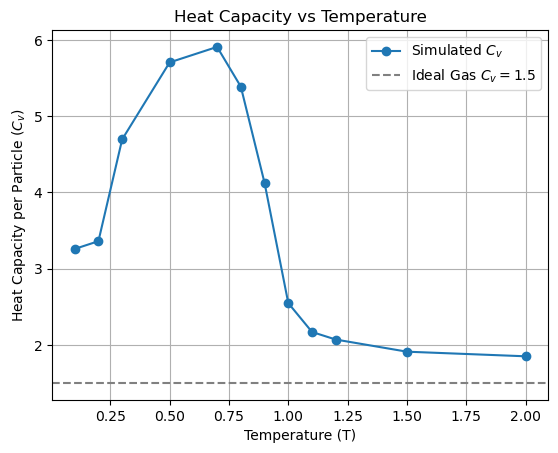

In [ ]:
# === Heat Capacity Estimation with NumPy ===
import numpy as np
import matplotlib.pyplot as plt

T_vals = np.array(successful_temperatures)
E_vals = np.array(temperature_averages)

# Ensure sorted (just in case)
sorted_indices = np.argsort(T_vals)
T_vals = T_vals[sorted_indices]
E_vals = E_vals[sorted_indices]

# Finite difference to estimate C_v = d<E>/dT
Cv_vals = np.zeros_like(E_vals)
Cv_vals[1:-1] = (E_vals[2:] - E_vals[:-2]) / (T_vals[2:] - T_vals[:-2])  # central diff
Cv_vals[0] = (E_vals[1] - E_vals[0]) / (T_vals[1] - T_vals[0])           # forward diff
Cv_vals[-1] = (E_vals[-1] - E_vals[-2]) / (T_vals[-1] - T_vals[-2])      # backward diff

# Plot C_v
plt.figure()
plt.plot(T_vals, Cv_vals, 'o-', label='Simulated $C_v$')
plt.axhline(1.5, color='gray', linestyle='--', label='Ideal Gas $C_v = 1.5$')
plt.xlabel('Temperature (T)')
plt.ylabel('Heat Capacity per Particle ($C_v$)')
plt.title('Heat Capacity vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

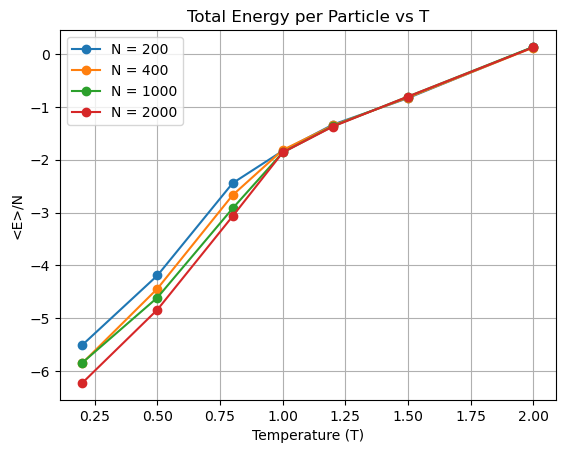

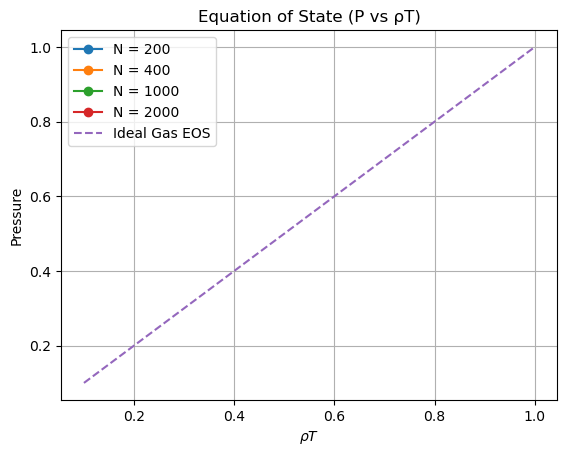

In [ ]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt

def run_simulation(N, temperatures, density=0.5, dt=0.005):
    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    L = (N / density)**(1/3)
    snapshot = hoomd.snapshot.Snapshot()
    snapshot.particles.N = N
    snapshot.particles.types = ['A']
    snapshot.particles.typeid[:] = [0] * N
    snapshot.particles.mass[:] = [1.0] * N
    snapshot.configuration.box = [L, L, L, 0, 0, 0]

    # Position initialization
    positions = []
    nx = ny = nz = int(np.ceil(N ** (1 / 3)))
    spacing = L / nx
    count = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if count < N:
                    x = (i + 0.5) * spacing - L / 2
                    y = (j + 0.5) * spacing - L / 2
                    z = (k + 0.5) * spacing - L / 2
                    positions.append([x, y, z])
                    count += 1
    snapshot.particles.position[:] = positions
    velocities = np.random.normal(0, np.sqrt(0.5), (N, 3))
    snapshot.particles.velocity[:] = velocities

    sim.create_state_from_snapshot(snapshot)

    # Interaction
    nl = hoomd.md.nlist.Cell(buffer=1)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5

    integrator = hoomd.md.Integrator(dt=dt)
    thermostat = hoomd.md.methods.thermostats.Bussi(kT=hoomd.variant.Constant(0.5))
    nvt = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=thermostat)
    integrator.methods.append(nvt)
    integrator.forces.append(lj)
    sim.operations.integrator = integrator

    # Thermo compute
    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermo)

    # Storage
    temperature_averages = []
    pressure_vals = []
    successful_temperatures = []

    for T in temperatures:
        nvt.thermostat.kT = hoomd.variant.Constant(T)
        try:
            sim.run(10000)

            energy_samples = []
            pressure_samples = []
            for _ in range(20):
                sim.run(500)
                ke = thermo.kinetic_energy
                pe = thermo.potential_energy
                energy_samples.append(ke + pe)
                pressure_samples.append(thermo.pressure)

            temperature_averages.append(np.mean(energy_samples) / N)
            pressure_vals.append(np.mean(pressure_samples))
            successful_temperatures.append(T)
        except RuntimeError:
            continue  # silently skip failed T

    return np.array(successful_temperatures), np.array(temperature_averages), np.array(pressure_vals)

# === Run for different system sizes ===
sizes = [200, 400, 1000, 2000]
temperatures = [0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]

results = {}
for N in sizes:
    T_vals, E_vals, P_vals = run_simulation(N, temperatures)
    results[N] = {'T': T_vals, 'E_per_N': E_vals, 'P': P_vals}

# === Plot <E>/N vs T ===
plt.figure()
for N in sizes:
    plt.plot(results[N]['T'], results[N]['E_per_N'], 'o-', label=f'N = {N}')
plt.xlabel('Temperature (T)')
plt.ylabel('<E>/N')
plt.title('Total Energy per Particle vs T')
plt.legend()
plt.grid(True)
plt.show()

# === Plot Pressure vs ρT ===
plt.figure()
for N in sizes:
    rho_T = [0.5 * T for T in results[N]['T']]  # ρ is constant
    plt.plot(rho_T, results[N]['P'], 'o-', label=f'N = {N}')
plt.plot(rho_T, rho_T, '--', label='Ideal Gas EOS')
plt.xlabel(r'$\rho T$')
plt.ylabel('Pressure')
plt.title('Equation of State (P vs ρT)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Summery:
# At low temperatures (T = 0.2), particles displayed strong structural ordering, as evident from sharp peaks in the radial distribution function g(r)—indicative of solid- or liquid-like phases.
# As the temperature increased (T ≥ 1.5), g(r) flattened toward 1, consistent with behavior seen in ideal gases.
# The average energy per particle (<E>/N) increased non-linearly with temperature, highlighting both kinetic and potential energy contributions.
# Heat capacity exceeded the ideal gas value (1.5 kB) at low temperatures, reflecting significant potential energy involvement, but gradually approached the ideal gas limit at higher temperatures.
# Lennard-Jones vs. Ideal Gas Behavior:
# At high temperatures, pressure scaled linearly with ρT, closely following the ideal gas law predictions.

# Challenges Encountered:
# This was the first time building a HOOMD model, and there were multiple code development and debugging hurdles.
# Several early simulations failed due to particle overlaps and boundary clipping errors.
# The Lennard-Jones system was notably sensitive to parameter choices, requiring careful tuning.

# Revelations:
# Observing the gradual transition from solid to liquid to gas with increasing temperature was particularly enlightening.
# The Lennard-Jones potential effectively captured realistic phase behavior, offering a more intuitive grasp of thermodynamic transitions compared to an idealized model.

# Favorite Simulation: T = 0.5, N = 400
# The g(r) at T = 0.5 exhibited distinct, well-formed peaks, indicating intermediate structural order.
# Pressure at this temperature was much lower than expected from the ideal gas equation of state.
# It highlighted the transition zone between solid-like and gas-like states
